In [1]:
import pytesseract
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os

Rencananya mau mulai bikin OCR KTP-nya

In [2]:
pytesseract.pytesseract.tesseract_cmd = 'C:/Users/Luis R/AppData/Local/Programs/Tesseract-OCR/tesseract.exe'
os.environ['TESSDATA_PREFIX'] = 'C:/Users/Luis R/AppData/Local/Programs/Tesseract-OCR/tessdata'

In [17]:
FILE_PATH = 'data_ktp/'
filePath = os.path.join(FILE_PATH, 'ktp1.png') 
print(filePath)

data_ktp/ktp1.png


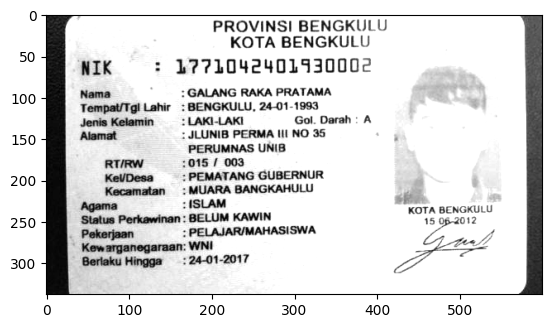

In [8]:
img = cv2.imread(filePath)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#plt.imshow(gray, cmap='gray')
th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_TRUNC)
plt.imshow(threshed, cmap='gray')

In [9]:
result = pytesseract.image_to_string(threshed, lang="ind")
print(result)

PROVINSI BENGKULU
KOTA BENGKULU

NIK : 1?771042401930002

Nama : GALANG RAKA PRATAMA
Tempat/Tgi Lahir : BENGKULU, 24-01-1993
Jenis Kelamin : LAKI-LAKI Gol. Darah : A
Alamat : JLUNIB PERMA III NO 35
PERUMNAS UNIB

RT/RW :015 / 003

KeDesa —— :PEMATANG GUBERNUR

Kecamatan : MUARA BANGKAHULU
Agama :ISLAM
Status Perkewinan : BELUM KAWIN

: PELAJAR/MAHASISWA

Pekerjaan :
Kewarganegaraan: WNI
Berlaku Hingga — :24-01-2017

B
KOTA BENGKULU

2&:…
73

Pa



In [10]:
class KTPInformation(object):
    def __init__(self):
        self.nik = ""
        self.nama = ""
        self.tempat_lahir = ""
        self.tanggal_lahir = ""
        self.jenis_kelamin = ""
        self.golongan_darah = ""
        self.alamat = ""
        self.rt = ""
        self.rw = ""
        self.kelurahan_atau_desa = ""
        self.kecamatan = ""
        self.agama = ""
        self.status_perkawinan = ""
        self.pekerjaan = ""
        self.kewarganegaraan = ""
        berlaku_hingga = "SEUMUR HIDUP"

In [11]:
import re
import json

In [18]:
class KTPOCR(object):
    def __init__(self, image):
        self.image = cv2.imread(image)
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        self.th, self.threshed = cv2.threshold(self.gray, 127, 255, cv2.THRESH_TRUNC)
        self.result = KTPInformation()
        self.master_process()

    def process(self, image):
        raw_extracted_text = pytesseract.image_to_string((self.threshed), lang="ind")
        return raw_extracted_text

    def word_to_number_converter(self, word):
        word_dict = {
            "L": "1",
            "l": "1",
            "O": "0",
            "o": "0",
            "?": "7",
            "A": "4",
            "Z": "2",
            "z": "2",
            "S": "5",
            "s": "5",
            "b": "6",
            "B": "8",
            "G": "6"
        }
        res = ""
        for letter in word:
            if letter in word_dict:
                res += word_dict[letter]
            else:
                res += letter
        return res
    def extract(self, extracted_result):
        #print(extracted_result.replace('\n', ' -- '))
        for word in extracted_result.split("\n"):
            word = self.pun_rem(word)

            if "NIK" in word:
              word = word.split(':')
              self.result.nik = self.word_to_number_converter(word[-1].replace(" ", ""))
              continue

            if "Nama" in word:
              word = word.split(':')
              self.result.nama = word[-1]
              continue

            if "Lahir" in word:
              word = word.split(':')
              self.result.tanggal_lahir = re.search("([0-9]{2}\-[0-9]{2}\-[0-9]{4})", word[-1])[0]
              self.result.tempat_lahir = word[-1].replace(self.result.tanggal_lahir, '')
              continue

            if "Gol" in word:
              word = word.split(':')
              self.result.jenis_kelamin = re.search("(LAKI-LAKI|LAKI|LELAKI|PEREMPUAN)", word[1])[0]
              # gol = re.search("(O|A|B|AB)", word[2])[0]

              # if gol == "0":
              #   gol = "O"

              # self.result.golongan_darah = gol
              continue

            if "Alamat" in word:
              self.result.alamat = re.sub(r'^\W*\w+\W*', '', word)
              continue

            if "RW" in word:
              word = re.sub(r'^\W*\w+\W*', '', word)

              if " " in word:
                a = word.split(" ")
              elif "/" in word:
                a = word.split("/")
              self.result.rt = a[0][-3:]
              self.result.rw = a[1][-3:]
              continue

            if "kel" in word:
              word = re.sub(r'^\W*\w+\W*', '', word)
              self.result.kecamatan = word
              continue

            if "Agama" in word:
              self.result.agama = re.search("(ISLAM|KRISTEN|KATOLIK|HINDU|BUDDHA|KONG HU CU)", word)[0]
              continue

            if "Status" in word:
              self.result.status_perkawinan = re.search("(KAWIN|BELUM KAWIN|DUDA CERAI|DUDA MATI|JANDA CERAI|JANDA MATI)", word)[0]
              continue

            if "Pekerjaan" in word:
              word = re.sub(r'^\W*\w+\W*', '', word)
              word = word.split(" ")
              self.result.pekerjaan = word[0]
              continue

            if "Kewarganegaraan" in word:
              self.result.kewarganegaraan = re.search("(WNI|WNA)", word)[0]
              continue

    def pun_rem(self,text):
      punctuations = '''!()[]{}'"\<>?@#$%^&*_~'''
      no_punct = ''

      for char in text:
        if char not in punctuations:
          no_punct = no_punct + char

      return no_punct

    def master_process(self):
        raw_text = self.process(self.image)
        self.extract(raw_text)

    def to_json(self):
        return json.dumps(self.result.__dict__, indent=4)          

In [19]:
images = KTPOCR(filePath)
print(images.to_json());

{
    "nik": "1771042401930002",
    "nama": " GALANG RAKA PRATAMA",
    "tempat_lahir": " BENGKULU, ",
    "tanggal_lahir": "24-01-1993",
    "jenis_kelamin": "LAKI-LAKI",
    "golongan_darah": "",
    "alamat": "JLUNIB PERMA III NO 35",
    "rt": "RW",
    "rw": "015",
    "kelurahan_atau_desa": "",
    "kecamatan": "",
    "agama": "ISLAM",
    "status_perkawinan": "BELUM KAWIN",
    "pekerjaan": "",
    "kewarganegaraan": "WNI"
}


Jangan di Run dulu

In [ ]:
import hashlib

class KTPOCR(object):
    def __init__(self, image):
        # Constructor code here...

    def validate_nik(self, nik):
        # Validating NIK format
        if len(nik) != 16 or not nik.isdigit():
            return False
        # Additional validation steps if needed
        return True

    def save_to_database(self):
        # Simpan NIK ke database
        if self.validate_nik(self.result.nik):
            # Lakukan penyimpanan ke database
            hashed_nik = hashlib.sha256(self.result.nik.encode()).hexdigest()
            # Simpan hashed_nik beserta informasi pengguna lainnya ke dalam database
            print("NIK tersimpan ke dalam database dengan aman.")
        else:
            print("NIK tidak valid, penyimpanan dibatalkan.")

    def check_duplicate_nik(self, nik):
        # Cek apakah NIK sudah ada dalam database
        # Kembalikan True jika ada, False jika tidak
        return False  # Implementasi sesuai dengan database yang digunakan

    def order_ticket(self, user_nik):
        # Proses pemesanan tiket
        if self.check_duplicate_nik(user_nik):
            print("Maaf, Anda sudah memesan tiket sebelumnya.")
        else:
            print("Pemesanan tiket berhasil.")

# Contoh penggunaan:
# images = KTPOCR(filePath)
# images.save_to_database()
# images.order_ticket(user_nik)


In [ ]:

# Path ke folder yang berisi gambar-gambar KTP
folder_path = "C:/Users/Luis R/Documents/Semester 6/Capstone/KTP-OCR/data"

# Mendapatkan daftar file dalam folder
file_list = os.listdir(folder_path)

# Loop melalui setiap file dalam folder
for file_name in file_list:
    # Membuat path lengkap untuk setiap file
    file_path = os.path.join(folder_path, file_name)
    
    # Membuat objek KTPOCR untuk setiap file gambar
    ktp_object = KTPOCR(file_path)
    
    # Melakukan proses-proses yang diperlukan
    ktp_object.save_to_database()
    ktp_object.order_ticket(user_nik)


Saya akan menghapus bagian di bawah ini dari file 'model_ktp_ocr.py' karena akan membawanya ke GitHub 

In [ ]:
if __name__ == "__main__":
    current_dir = os.path.dirname(__file__)
    FILE_PATH = os.path.join(current_dir, 'data_ktp/')
    filePath = os.path.join(FILE_PATH, 'ktp4.jpg')
    images = KTPOCR(filePath)
    print(images.to_json())